In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

In [2]:
df = (
    pd.read_csv('job_classification.csv')
    .drop(columns='Unnamed: 0')
    .rename(columns={'class_id': 'label'})
    .dropna()
)
df

,label,title,description
0,3,Airport Butler - Concierge,Requisition Number Numro de rquisition 16-078...
1,3,Los Angeles Airport - LAX - Commercial Aviatio...,"AccuFleet is looking for a ""hands-on"" operatio..."
2,3,AIRPORT POLICE OFFICER 3225,"DUTIES $62,118 to $94,732 Salary range applies..."
3,3,Airport Operations Manager,[COMPANY] is committed to being globally compe...
4,3,LAX Airport Customer Service Pool,[COMPANY] is hiring at LAX for Customer Servic...
...,...,...,...
2055,1,HEALTH FACILITIES EVALUATOR II (SUPERVISOR),Equal Opportunity Employer The State of Califo...
2056,1,Food Service Worker,Apply on Citrus Valley Health Partners gc inse...
2057,1,Public Health Nutritionist I - Supervisory,CAREER DESCRIPTION PUBLIC HEALTH NUTRITIONIST ...
2058,1,Intake Specialist - Behavioral [COMPANY]ealth ...,Job Overview Are you Bilingual in Spanish? Do ...


In [3]:
df['label'].value_counts(normalize=True)

3    0.242218
0    0.155642
5    0.155642
2    0.155156
4    0.155156
1    0.136187
Name: label, dtype: float64

In [4]:
df['description'].str.split().map(len).describe()

count    2056.000000
mean      484.623054
std       147.511159
min         1.000000
25%       467.750000
50%       544.000000
75%       573.000000
max       669.000000
Name: description, dtype: float64

In [5]:
df['text'] = df['title'] + '\n' + df['description']

In [6]:
np.random.seed(22)

train_df, test_df = train_test_split(df, test_size=.2, stratify=df['label'])
len(train_df), len(test_df)

(1644, 412)

# SetFit

In [7]:
train_subset, _ = train_test_split(train_df, train_size=200, stratify=train_df['label'])

train_ds = Dataset.from_pandas(train_subset)
test_ds = Dataset.from_pandas(test_df)

In [8]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [9]:
trainer.train()

***** Running training *****
  Num examples = 8000
  Num epochs = 1
  Total optimization steps = 500
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [10]:
trainer.evaluate()

***** Running evaluation *****


{'accuracy': 0.7087378640776699}

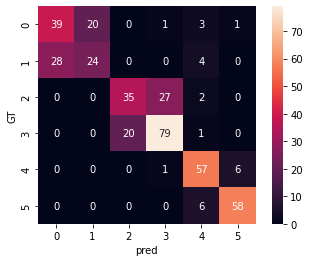

In [11]:
test_pred = trainer.model.predict(test_df.reset_index()['text'])
sns.heatmap(confusion_matrix(test_df['label'], test_pred),
            annot=True,
            square=True)
plt.xlabel('pred')
plt.ylabel('GT');

In [12]:
vectorizer = TfidfVectorizer(use_idf=False, stop_words='english')

mega_texts = train_df.groupby('label')['text'].apply(lambda texts: '\n'.join(texts))

mega_tf = vectorizer.fit_transform(mega_texts)
mega_tf = pd.DataFrame(mega_tf.todense(),
                       columns=vectorizer.get_feature_names_out()).T


pd.DataFrame({
    label: mega_tf[label].sort_values(ascending=False).index
    for label in range(6)
}).head()

,0,1,2,3,4,5
0,health,health,service,work,water,water
1,care,care,work,airport,work,resources
2,experience,services,airport,service,experience,engineering
3,company,experience,company,required,company,experience
4,patient,department,customer,company,service,design


In [13]:
(
    train_df.groupby('label')['text']
    .apply(lambda texts: texts.str.lower().str.contains('water').mean())
)

label
0    0.011719
1    0.022321
2    0.101961
3    0.057789
4    0.925490
5    0.992188
Name: text, dtype: float64

In [14]:
vectorizer = TfidfVectorizer(use_idf=True, stop_words='english', min_df=5, sublinear_tf=True)

vec_df = vectorizer.fit_transform(train_df['text'])
vec_df = pd.DataFrame(vec_df.todense(), columns=vectorizer.get_feature_names_out())

vec_df

,00,000,001,00am,00pm,01,02,03,04,06,...,year,yearly,years,yes,yield,york,youth,zealand,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.056445,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.057166,0.0,0.051857,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054875,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.046957,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
pd.DataFrame({label: vec_df.columns[np.argsort(chi2(vec_df, train_df['label'] == label)[1])]
              for label in range(6)}).head(20)

,0,1,2,3,4,5
0,clinical,health,rent,airport,water,resources
1,patients,patient,enterprise,lax,distribution,hec
2,health,department,car,water,operator,civil
3,patient,nursing,rental,wayne,wastewater,stormwater
4,care,care,hospitality,ramp,meter,engineering
5,hospital,county,airport,aircraft,meters,engineer
6,nursing,mental,guest,health,plant,modeling
7,massachusetts,nurse,lot,john,valves,hydrologic
8,baystate,community,dfw,stand,plants,water
9,therapy,medical,alamo,lift,hydrants,hydraulic


In [16]:
(
    train_df[(~train_df['text'].str.lower().str.contains('wayne')) &
             (train_df['text'].str.lower().str.contains('airport')) &
             (train_df['label'] == 3)]['text']
    .sample(1)
    .iloc[0]
)

"LAX - Airport Coordinator (Summer 2018)\nLAX Airport Coordinator (Summer 2018) at [COMPANY]ustic Pathways The Company [COMPANY]ustic Pathways is a student travel organization which offers the world's finest experiential education, community service, foreign language, and adventure programs. Our destinations stretch from the white-sand beaches of Fiji to the rainforest canopies of Costa [COMPANY]ica to the Great Barrier [COMPANY]eef, and many places in between. We provide superior quality travel and service in some of the most welcoming countries for students... around the world. [COMPANY]ustic Pathways demands professionalism and integrity across all of our operations, insists on quality in all aspects of our programs, and places strong emphasis on the safety and well-being of our students and staff. We empower students through innovative and responsible travel experiences to positively impact lives and communities around the world. The Position This position is for highly motivated a

In [17]:
(
    train_df[(train_df['text'].str.lower().str.contains('airport')) &
             (train_df['label'] == 2)]['text']
    .sample(1)
    .iloc[0]
)

"Airport Cashier\nPrincipal Job Duties  Complete all required paperwork and reports accurately and efficiently to account for all collected parking revenues.  Greet by/use name, be responsive and timely with correspondence and problem resolution, and display a caring attitude, develop a rapport with the customer base.  Assist customers in lobbies, lanes, and in the parking office; help direct traffic.  Promote good customer relations by consistently providing premier customer satisfaction with a friendly... demeanor, can-do attitude, and willingness to help at all times.  Accept monthly and debit payments and process credit cards.  Basic computer skills in the parking revenue control system (add/delete accounts, key in required information from monthly applications).  Responsible for running any reports related to daily revenue, credit cards, or garage data.  Must work with or without supervision.  Responsible for general maintenance of the garage - sweeping, wiping down surfaces and e